In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier

import helpers as h
import models as clsf

np.random.seed(69)

Number of cores to use: 4


# Data Preprocessing

In [2]:
train_df0 = pd.read_csv('train.csv')
X0_df, Y_c0, Y0 = h.transform_df(train_df0, train=True, as_df=True)
X0 = X0_df.values
(N, d) = X0.shape

# Grid Search

In [3]:
### Just gonna take a random 10th for validation
X, valX, Y_c, valY_c, Y, valY = train_test_split(X0, Y_c0, Y0, shuffle=True, test_size=0.1)
pars = h.get_pars_for_processing(X)
X, valX = h.process_with_pars(X, pars), h.process_with_pars(valX, pars)

t_size, v_size = X.shape[0] // 100, valX.shape[0] // 100
train_res, test_res, models = clsf.TuneClassifiers(X[:t_size], valX[:v_size], Y[:t_size], valY[:v_size], algs=['RF'])
test_res

Tuning RF ...
Tuned in: 188.74616980552673
{'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 100}


,Classifier,Type,Tuning,Accuracy,AUC
1,RF,test,base,0.569981,0.602136
3,RF,test,tuned,0.562046,0.595707


# Cross Validation

In [4]:
clf = RandomForestClassifier(**models['RF'].best_params_)
aucs, accs = clsf.cross_val(clf, X0, Y_c0, (h.get_pars_for_processing, h.process_with_pars))
aucs.mean(), accs.mean()

CV fold: 3it [03:38, 72.71s/it] 


(0.6559184091985576, 0.6582430196833113)

# Final Fitting

In [5]:
pars = h.get_pars_for_processing(X0)
process = lambda x: h.process_with_pars(x, pars)
clf.fit(process(X0), Y_c0);

# Feature Importances

In [19]:
inds = np.array(sorted(range(len(X0_df.columns)), \
                       key=lambda x: clf.feature_importances_[x], \
                       reverse=True))
imp_dict = dict(zip(X0_df.columns[inds], clf.feature_importances_[inds]))
imp_dict

{'last_price': 0.1259573479059924,
 'bid_w5': 0.08985212475293208,
 'ask_w5': 0.0893505332034838,
 'bid_w4': 0.08645829122303782,
 'ask_w4': 0.08580468765250876,
 'ask_w3': 0.08125858523123614,
 'bid_w3': 0.08117992160169502,
 'ask_w1': 0.07691410813006198,
 'ask_w2': 0.07252094242978785,
 'bid_w2': 0.07218414708580338,
 'bid_w1': 0.06107519376735983,
 'transacted_qty': 0.024595074664124045,
 'd_open_interest': 0.021866056045701042,
 'closed_position_qty': 0.017094806948421554,
 'opened_position_qty ': 0.013888179357854358}

# Get Predictions on Test Set

In [6]:
test_df0 = pd.read_csv('test.csv')
tX = h.transform_df(test_df0)
tX = process(tX)

output = clf.predict_proba(tX)[:, 1]
     
output_df = pd.DataFrame({'id':test_df0['id'], 'Predicted': output})
output_df.to_csv('submission.csv', index=False)

# Sanity checks on output

mean of train_labels: 0.3569583713157095
mean of train_preds: 0.41247777257364965


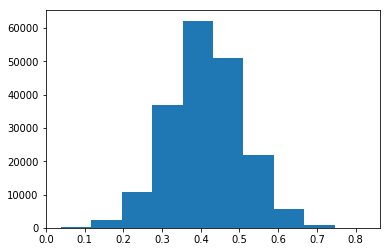

In [7]:
assert(np.all((0 <= output) & (output <= 1)))
print(f'mean of train_labels: {np.mean(Y_c0)}')
print(f'mean of train_preds: {np.mean(output)}')
plt.hist(output);